In [10]:
#!pip install kaggle

In [11]:
#!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [12]:
#!kaggle datasets download -d sixhky/open-images-bus-trucks/


In [13]:
#!unzip -qq open-images-bus-trucks.zip

In [14]:
## Download necessaries
!pip install -q selectivesearch
#!pip install -q torch_snippets


In [15]:
#from torchvision.ops import nms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from torchvision import transforms, models, datasets
from torch_snippets import *
import selectivesearch

In [16]:
IMAGE_ROOT = 'images/images'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
image_id="00006bdb1eb5cd74"
image_path = os.path.join(IMAGE_ROOT,image_id+'.jpg')
image = cv2.imread(image_path, 1)[...,::-1] # conver BGR to RGB
h, w, _ = image.shape


In [18]:
DF_RAW = pd.read_csv('df.csv')
df = DF_RAW[DF_RAW['ImageID'] == image_id]
boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist()
classes = df['LabelName'].values.tolist()

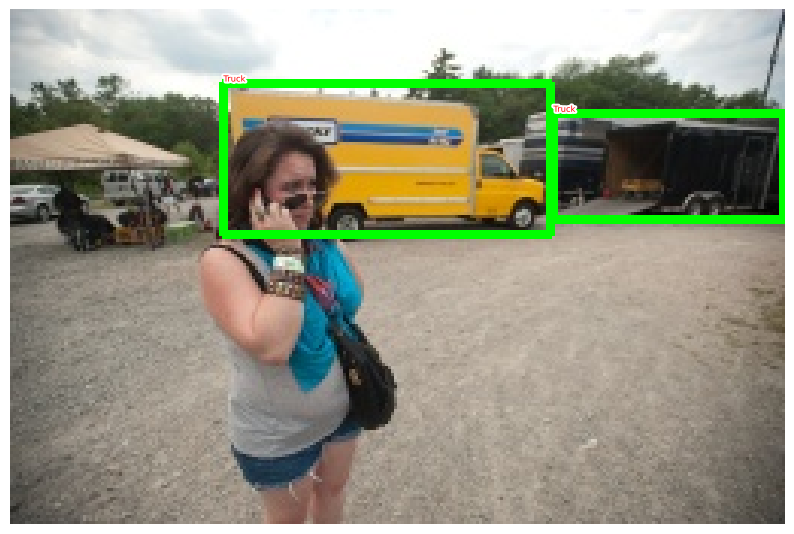

In [19]:
show(image, bbs=boxes, texts=classes, sz=10)

In [20]:
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates

def extract_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

In [21]:
candidates = extract_candidates(image) # x,y,w,h

candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])

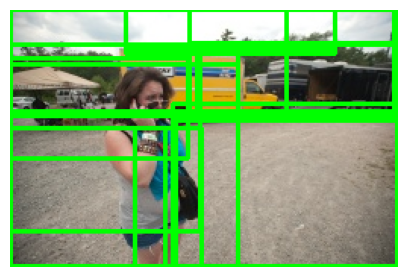

In [22]:

show(image, bbs = candidates)

In [23]:
H, W, _ = image.shape


rixs,ious, rois, clss, deltas = [], [], [], [], []
ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in boxes ]).T
for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
        candidate_ious = ious[jx] # GT IOU

        best_iou_at = np.argmax(candidate_ious) # maxium IOU  GT
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = boxes[best_iou_at]

        if best_iou > 0.3: clss.append(classes[best_iou_at])
        else : clss.append('background')

        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.extend(delta)
        rois.append(candidate / np.array([W,H,W,H]))
rixs.extend([0]*len(candidates))

In [24]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()
def decode(_y):
    _, preds = _y.max(-1)
    return preds


In [25]:
image = cv2.resize(image, (224,224))
image =preprocess_image(image/255.)[None]
print(image.shape)

torch.Size([1, 3, 224, 224])

In [26]:

vgg_backbone = torchvision.models.vgg16_bn(pretrained=True).cuda()
for param in vgg_backbone.features.parameters():
            param.requires_grad = True
seq = nn.Sequential(*list(vgg_backbone.features.children())[:-1])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
features = seq(image)
features.shape

torch.Size([1, 512, 14, 14])

In [28]:
14/224

0.0625

In [29]:
from torchvision.ops import RoIPool
roipool = RoIPool(7, spatial_scale=14/224)

In [30]:
rois = torch.Tensor(rois).float().to(device)
rixs = torch.Tensor(rixs).float().to(device)

<ipython-input-30-bef918238410>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  rois = torch.Tensor(rois).float().to(device)


In [31]:
rixs.unsqueeze(-1).shape

torch.Size([33, 1])

In [32]:
rois.shape

torch.Size([33, 4])

In [33]:
rois = torch.cat([rixs.unsqueeze(-1), rois*224], dim=-1)

In [34]:

roipool(features, rois).shape

torch.Size([33, 512, 7, 7])